In [1]:
import argparse
from numpy.core.numeric import cross
import yaml
import warnings
import pandas as pd
import glob, os
import logging
from scipy import stats
from typing import Tuple
import tensorflow as tf
import numpy as np                                                         
from utils.data_loader import load_coat, load_synthetic, load_yahoo
from trainer import train_mf, train_mf_kfold, train_expoMF
from evaluate.metrics import evaluator, evaluator_ranking

In [2]:
!pip install matplotlib

In [3]:
def load_yahoo() -> Tuple[np.ndarray, np.ndarray]:
    """
    load_yahoo Loads yahoo dataset

    Returns:
        Tuple[np.ndarray, np.ndarray]: train, test dataset
    """    
    cols = ['uid', 'pid', 'rating']
    dir_path = '../data/raw/yahoo'
    train_df = pd.read_csv(os.path.join(dir_path, 'ydata-ymusic-rating-study-v1_0-train.txt'),\
                    delimiter='\t', names=cols)
    test_dir_path = '../data/processed/'
    test_df = pd.read_csv(os.path.join(test_dir_path, 'eval_split.dat'),\
                    delimiter='\t', names=cols)
    prop_df = pd.read_csv(os.path.join(test_dir_path, 'prop_split.dat'),\
                    delimiter='\t', names=cols)

    # train_raw_matrix = np.loadtxt(os.path.join('./data/raw/coat', 'train.ascii'))
    # test_raw_matrix = np.loadtxt(os.path.join('./data/raw/coat', 'test.ascii'))
    item_feats = np.loadtxt('../data/processed/item_attr_matrix.txt')
    # train_df = pd.DataFrame(
    #     {'uid': np.nonzero(train_raw_matrix)[0].tolist(),
    #     'pid': np.nonzero(train_raw_matrix)[1].tolist(),
    #     'rating': train_raw_matrix[np.nonzero(train_raw_matrix)]
    #     })
    
    # test_df = pd.DataFrame(
    #     {'uid': np.nonzero(test_raw_matrix)[0].tolist(),
    #     'pid': np.nonzero(test_raw_matrix)[1].tolist(),
    #     'rating': test_raw_matrix[np.nonzero(test_raw_matrix)]
    #     })

    col_names = []
    n_clusts = item_feats.shape[1]
    n_users = np.unique(train_df['uid']).shape[0]
    for i in range(n_clusts):
        col_names.append('f'  + str(i))
    
    col_name_df = {}
    for i, col_name in enumerate(col_names):
        col_name_df[col_name] = item_feats[:, i]
        col_name_df['pid'] = range(0, item_feats.shape[0])
    
    item_feats_df = pd.DataFrame(col_name_df)
    train_df_item = train_df.merge(item_feats_df, on='pid')
    test_df_item = test_df.merge(item_feats_df, on='pid')
    prop_df_item = prop_df.merge(item_feats_df, on='pid')

    # Generating user * attribute matrix
    col_names_idx = dict(zip(col_names, range(len(col_names))))
    user_attr_train = np.zeros((n_users, len(col_names)))
    user_attr_train_count = np.zeros((n_users, len(col_names)))

    user_attr_test = np.zeros((n_users, len(col_names)))
    user_attr_test_count = np.zeros((n_users, len(col_names)))

    user_attr_prop = np.zeros((n_users, len(col_names)))
    user_attr_prop_count = np.zeros((n_users, len(col_names)))

    
    for j, row in train_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_train[int(row['uid'])-1, idx] += row['rating']
    
    for j, row in train_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_train_count[int(row['uid'])-1, idx] += 1
            
    for j, row in test_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_test[int(row['uid'])-1, idx] += row['rating']
    
    for j, row in test_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_test_count[int(row['uid'])-1, idx] += 1

    for j, row in prop_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_prop[int(row['uid'])-1, idx] += row['rating']
    
    for j, row in prop_df_item.iterrows():
        for col_name, idx in col_names_idx.items():
            if int(row[col_name]) == 1:
                user_attr_prop_count[int(row['uid'])-1, idx] += 1


    # replace count of ratings with average rating
    user_attr_train /= user_attr_train_count
    user_attr_test /= user_attr_test_count
    user_attr_prop /= user_attr_prop_count
    # replace division with 0 with -1
    user_attr_train[np.isnan(user_attr_train)] = 0
    user_attr_test[np.isnan(user_attr_test)] = 0
    user_attr_prop[np.isnan(user_attr_prop)] = 0
    # Convert float values to nearest int
    user_attr_train = np.ceil(user_attr_train)
    user_attr_test = np.ceil(user_attr_test)
    user_attr_prop = np.ceil(user_attr_prop)

    # train & test user * attribute dataframe
    train_ua_df = pd.DataFrame(
    {'uid': np.nonzero(user_attr_train)[0].tolist(),
     'pid': np.nonzero(user_attr_train)[1].tolist(),
     'rating': user_attr_train[np.nonzero(user_attr_train)]
    })

    # np.random.seed(12345)
    # msk = np.random.rand(len(train_ua_df)) < 0.9
    
    # train_split_df = train_ua_df[msk]
    # valid_split_df = train_ua_df[~msk]


    test_ua_df = pd.DataFrame(
    {'uid': np.nonzero(user_attr_test)[0].tolist(),
     'pid': np.nonzero(user_attr_test)[1].tolist(),
     'rating': user_attr_test[np.nonzero(user_attr_test)]
    })

    prop_ua_df = pd.DataFrame(
    {'uid': np.nonzero(user_attr_prop)[0].tolist(),
     'pid': np.nonzero(user_attr_prop)[1].tolist(),
     'rating': user_attr_prop[np.nonzero(user_attr_prop)]
    })
    
    return (train_df_item, test_df_item, train_ua_df, test_ua_df, prop_ua_df, item_feats_df)

In [4]:
config = yaml.safe_load(open('../config/consts.yaml', 'rb'))

In [5]:
res = load_yahoo()

/home/sgupta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide
/home/sgupta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/home/sgupta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


In [6]:
cross_val_files = glob.glob('../reports/results/cross_val_results_*')

In [7]:
len(cross_val_files)

19

In [8]:
df_results = []
for cross_val_file in cross_val_files:
    df_res = pd.read_csv(cross_val_file, delimiter='\t')
    df_results.append(df_res)
df_params = pd.concat(df_results, ignore_index=True)
print(df_params)

   Dataset  Method  lf_dim  reg_param       MSE
0    Yahoo      MF      40   0.000010  2.477533
1    Yahoo  MF-IPS      40   0.000010  1.864583
2    Yahoo  ExpoMF      40   0.000010  3.776678
3    Yahoo      MF      10   0.010000  2.856141
4    Yahoo  MF-IPS      10   0.010000  1.803867
5    Yahoo  ExpoMF      10   0.010000  2.864383
6    Yahoo      MF      40   0.001000  2.707495
7    Yahoo  MF-IPS      40   0.001000  1.580855
8    Yahoo  ExpoMF      40   0.001000  3.786762
9    Yahoo      MF       5   0.000001  2.109482
10   Yahoo  MF-IPS       5   0.000001  1.471964
11   Yahoo  ExpoMF       5   0.000001  2.409982
12   Yahoo      MF      10   0.000001  2.288510
13   Yahoo  MF-IPS      10   0.000001  1.636119
14   Yahoo  ExpoMF      10   0.000001  2.878583
15   Yahoo      MF      10   0.000100  2.348285
16   Yahoo  MF-IPS      10   0.000100  1.568825
17   Yahoo  ExpoMF      10   0.000100  2.880083
18   Yahoo      MF      40   0.000100  2.350146
19   Yahoo  MF-IPS      40   0.000100  1

In [9]:
df_params.columns[0]

'Dataset'

In [10]:
df_params = df_params[df_params['Dataset'] == 'Yahoo'].reset_index()
df_params_mf = df_params[df_params['Method'] == 'MF'].reset_index()
df_params_mfips = df_params[df_params['Method'] == 'MF-IPS'].reset_index()
df_params_expomf = df_params[df_params['Method'] == 'ExpoMF'].reset_index()

best_param_idx_mf = df_params_mf['MSE'].idxmin()
best_param_idx_mfips = df_params_mfips['MSE'].idxmin()
best_param_idx_expomf = df_params_expomf['MSE'].idxmin()


In [11]:
best_param_idx_expomf

16

In [12]:
df_params_expomf

,level_0,index,Dataset,Method,lf_dim,reg_param,MSE
0,2,2,Yahoo,ExpoMF,40,0.000010,3.776678
1,5,5,Yahoo,ExpoMF,10,0.010000,2.864383
2,8,8,Yahoo,ExpoMF,40,0.001000,3.786762
3,11,11,Yahoo,ExpoMF,5,0.000001,2.409982
4,14,14,Yahoo,ExpoMF,10,0.000001,2.878583
5,17,17,Yahoo,ExpoMF,10,0.000100,2.880083
6,20,20,Yahoo,ExpoMF,40,0.000100,3.778452
7,23,23,Yahoo,ExpoMF,20,0.000001,3.436293
8,26,26,Yahoo,ExpoMF,40,0.000001,3.789102
9,29,29,Yahoo,ExpoMF,10,0.001000,2.886076


In [13]:
lf_dim_best_mf, reg_param_best_mf = df_params_mf.iloc[best_param_idx_mf]['lf_dim'],\
                                    df_params_mf.iloc[best_param_idx_mf]['reg_param']

lf_dim_best_mfips, reg_param_best_mfips = df_params_mfips.iloc[best_param_idx_mfips]['lf_dim'],\
                            df_params_mfips.iloc[best_param_idx_mfips]['reg_param']

lf_dim_best_expomf, reg_param_best_expomf = df_params_expomf.iloc[best_param_idx_expomf]['lf_dim'],\
                            df_params_expomf.iloc[best_param_idx_expomf]['reg_param']

In [14]:
train_df_item, test_df_item, train_ua_df, test_ua_df, prop_ua_df, item_feats_df = res[0], res[1], res[2], res[3], res[4], res[5]

In [15]:
train_df_item['pid'].max()

999

In [34]:
import pdb
X_test = [test_ua_df[['uid', 'pid']].values[:, 0], test_ua_df[['uid', 'pid']].values[:, 1]]
y_gt = test_ua_df['rating'].values
# train MF plain model
per_dict = {}
per_dict_ips = {}
print("Starting cross-val hyper-param tuning")
#for ulf_dim in ulf_range:
#for ilf_dim in ilf_range:
#for reg_param in reg_param_range:
#ulf_dim = args.user_lf
#reg_param = args.reg_param

maes_mf, mses_mf, maes_mfips, mses_mfips, maes_expomf, mses_expomf = [], [], [], [], [], []
ndcgs_mf, ndcgs_mfips, ndcgs_expomf = [], [], []

logging.info('Starting final %d runs for COAT data to get models performance metric'%(config['runs']))
runs = 10
kurtosis_mf = 0.0
kurtosis_mfips = 0.0
kurtosis_expomf = 0.0
kl_mf = 0.0
kl_mfips = 0.0
kl_expomf = 0.0

for run in range(runs):
    history_mf = train_mf(train_ua_df, test_ua_df, prop_ua_df, \
                ulf_dim=lf_dim_best_mf, ilf_dim=lf_dim_best_mf, reg_param=reg_param_best_mf, \
                ips=0, config=config)
    print("MF trained")
    history_mfips = train_mf(train_ua_df, test_ua_df, prop_ua_df, \
                    ulf_dim=lf_dim_best_mfips, ilf_dim=lf_dim_best_mfips, reg_param=reg_param_best_mfips, \
                        ips=1, config=config)
    print("MF-IPS trained")
    history_expomf = train_expoMF(train_ua_df, test_ua_df,  \
                    ulf_dim=lf_dim_best_expomf, reg_param=reg_param_best_expomf, \
                        ips=1, config=config, logging=logging)
    print("expoMF trained")
    user_topic_scores = (history_mf.model.get_weights()[2] * (history_mf.model.get_weights()[0] @ history_mf.model.get_weights()[1].T) + history_mf.model.get_weights()[3] )
    user_topic_scores_expomf = (history_expomf.theta @ history_expomf.beta.T) 
    user_topic_scores_ips = (history_mfips.model.get_weights()[2] * (history_mfips.model.get_weights()[0] @ history_mfips.model.get_weights()[1].T) + history_mfips.model.get_weights()[3] )
    
    count_mf = Counter((user_topic_scores).argmax(axis=1).flatten())
    count_mf = {k: v for k, v in sorted(count_mf.items(), key=lambda item: item[1])}
    count_mf = np.array(list(count_mf.values()))/ sum(count_mf.values())
    unif_mf = [1/float(len(count_mf))] * len(count_mf)
    #pdb.set_trace()
    kl_mf += sum(kl_div(count_mf, unif_mf))
    
    count_mfips = Counter((user_topic_scores_ips).argmax(axis=1).flatten())
    count_mfips = {k: v for k, v in sorted(count_mfips.items(), key=lambda item: item[1])}
    count_mfips = np.array(list(count_mfips.values()))/ sum(count_mfips.values())
    unif_mfips = [1/float(len(count_mfips))] * len(count_mfips)
    #pdb.set_trace()
    kl_mfips += sum(kl_div(count_mfips, unif_mfips))
    
    count_expomf = Counter((user_topic_scores_expomf).argmax(axis=1).flatten())
    count_expomf = {k: v for k, v in sorted(count_expomf.items(), key=lambda item: item[1])}
    count_expomf = np.array(list(count_expomf.values()))/ sum(count_expomf.values())
    unif_expomf = [1/float(len(count_expomf))] * len(count_expomf)
    #pdb.set_trace()
    kl_expomf += sum(kl_div(count_expomf, unif_expomf))
    
    
    kurtosis_mfips += kurtosis(list(Counter((user_topic_scores_ips).argmax(axis=1).flatten()).values()))
    kurtosis_mf += kurtosis(list(Counter((user_topic_scores+1).argmax(axis=1).flatten()).values()))
    kurtosis_expomf += kurtosis(list(Counter((user_topic_scores_expomf).argmax(axis=1).flatten()).values()))

    print("Kurtosis-Expomf %f"%(kurtosis_expomf))
    print("Kurtosis-mf %f"%(kurtosis_mf))
    print("Kurtosis-mf IPS %f"%(kurtosis_mfips))
    
    print("kl-Expomf %f"%(kl_expomf))
    print("KL-mf %f"%(kl_mf))
    print("KL-mf IPS %f"%(kl_mfips))

Starting cross-val hyper-param tuning
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 5)         77000       input_8[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 5)         750         input_9[0][0]                    
______________________________________________________

MF-IPS trained
expoMF trained
Kurtosis-Expomf 62.909689
Kurtosis-mf 33.461535
Kurtosis-mf IPS 26.658448
kl-Expomf 1.910567
KL-mf 1.947596
KL-mf IPS 2.505435
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 5)         77000       input_16[0][0]                   
__________________________________________________________________________________________________
embedding_16 (Embedding)        (N

MF-IPS trained
expoMF trained
Kurtosis-Expomf 92.290703
Kurtosis-mf 100.826516
Kurtosis-mf IPS 48.987686
kl-Expomf 3.753697
KL-mf 4.126713
KL-mf IPS 4.867712
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1, 5)         77000       input_24[0][0]                   
__________________________________________________________________________________________________
embedding_24 (Embedding)        

MF-IPS trained
expoMF trained
Kurtosis-Expomf 111.132336
Kurtosis-mf 146.961998
Kurtosis-mf IPS 68.556909
kl-Expomf 5.821991
KL-mf 6.209306
KL-mf IPS 7.251119
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 1, 5)         77000       input_32[0][0]                   
__________________________________________________________________________________________________
embedding_32 (Embedding)       

MF-IPS trained
expoMF trained
Kurtosis-Expomf 155.508229
Kurtosis-mf 196.705742
Kurtosis-mf IPS 93.895801
kl-Expomf 7.673480
KL-mf 8.112213
KL-mf IPS 9.726076
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 1, 5)         77000       input_40[0][0]                   
__________________________________________________________________________________________________
embedding_40 (Embedding)       

MF-IPS trained
expoMF trained
Kurtosis-Expomf 183.448952
Kurtosis-mf 251.263856
Kurtosis-mf IPS 121.927596
kl-Expomf 9.561956
KL-mf 10.063884
KL-mf IPS 12.341908


In [35]:
kurtosis([3,1,2])

-1.5

In [36]:
print("Kurtosis-Expomf %f"%(kurtosis_expomf/10))
print("Kurtosis-mf %f"%(kurtosis_mf/10))
print("Kurtosis-mf IPS %f"%(kurtosis_mfips/10))

Kurtosis-Expomf 18.344895
Kurtosis-mf 25.126386
Kurtosis-mf IPS 12.192760


In [37]:
print("kl-Expomf %f"%(kl_expomf/10))
print("KL-mf %f"%(kl_mf/10))
print("KL-mf IPS %f"%(kl_mfips/10))

kl-Expomf 0.956196
KL-mf 1.006388
KL-mf IPS 1.234191


In [318]:
history_mf.history

{'loss': [7.087019443511963,
  1.223165512084961,
  0.8820462822914124,
  0.8666879534721375,
  0.8511831760406494,
  0.826255738735199,
  0.7945048809051514,
  0.7547330260276794,
  0.7128660678863525,
  0.6650223731994629]}

In [20]:
user_topic_scores = (history_mf.model.get_weights()[2] * (history_mf.model.get_weights()[0] @ history_mf.model.get_weights()[1].T) + history_mf.model.get_weights()[3] )

In [21]:
Counter(user_topic_scores.argmax(axis=1).flatten())

Counter({138: 4027,
         119: 107,
         3: 227,
         70: 65,
         23: 201,
         96: 1296,
         144: 703,
         15: 152,
         43: 74,
         132: 769,
         113: 135,
         19: 221,
         76: 281,
         5: 312,
         130: 357,
         58: 648,
         112: 636,
         29: 173,
         116: 1077,
         49: 176,
         54: 665,
         105: 313,
         69: 73,
         83: 68,
         120: 39,
         78: 96,
         121: 79,
         106: 17,
         128: 471,
         18: 227,
         118: 104,
         134: 57,
         80: 40,
         44: 240,
         141: 10,
         109: 92,
         101: 68,
         50: 78,
         74: 52,
         12: 37,
         85: 127,
         38: 207,
         48: 21,
         131: 31,
         33: 111,
         97: 41,
         60: 29,
         94: 11,
         16: 11,
         100: 14,
         93: 26,
         143: 55,
         148: 22,
         63: 52,
         73: 14,
         61: 11

In [22]:
user_topic_scores.argmax(axis=1).shape

(15400,)

In [23]:
from collections import Counter
#topic_counts = list(Counter(user_topic_scores.astype(np.int).flatten()).values())
topic_counts = list(Counter(user_topic_scores.argmax(axis=1).flatten()).values())
plot.bar(range(len(topic_counts)),sorted(topic_counts, reverse=True),align='center')
#list(Counter(user_topic_scores.argmax(axis=1)).values())

NameError: name 'plot' is not defined

In [24]:
len(Counter((user_topic_scores+1).argmax(axis=1).flatten()))

75

In [25]:
(user_topic_scores_ips+1).argmax(axis=1).shape

(15400,)

In [26]:
user_topic_scores_ips = (history_mfips.model.get_weights()[2] * (history_mfips.model.get_weights()[0] @ history_mfips.model.get_weights()[1].T) + history_mfips.model.get_weights()[3] )

In [27]:
#topic_counts = list(Counter((user_topic_scores_ips+1).astype(np.int).flatten()).values())
topic_counts = list(Counter((user_topic_scores_ips+1).argmax(axis=1).flatten()).values())
plot.bar(range(len(topic_counts)),sorted(topic_counts, reverse=True),align='center')


NameError: name 'plot' is not defined

In [28]:
len(Counter((user_topic_scores_ips+1).argmax(axis=1).flatten()))

69

In [29]:
from scipy.stats import norm, kurtosis
from scipy.special import kl_div

In [30]:
kurtosis(list(Counter((user_topic_scores_ips).argmax(axis=1).flatten()).values()))

14.53215055152788

In [32]:
kurtosis(list(Counter((user_topic_scores).argmax(axis=1).flatten()).values()))

39.995986862700654

In [99]:
Counter(user_topic_scores.argmax(axis=1))

Counter({11: 135, 31: 30, 22: 1, 19: 17, 2: 73, 8: 3, 12: 1, 4: 23, 25: 7})

In [222]:
y_pred_mf = history_mf.model.predict(X_test)
y_pred_mfips = history_mfips.model.predict(X_test)

In [228]:
Counter(y_pred_mf.flatten().astype(np.int))

Counter({3: 1476, 2: 2509, 1: 711, 4: 183, 5: 11})

In [229]:
Counter(y_pred_mfips.flatten().astype(np.int))

Counter({4: 156, 2: 2320, 3: 979, 1: 1399, 0: 24, 5: 12})

AttributeError: 'Line2D' object has no property 'density'

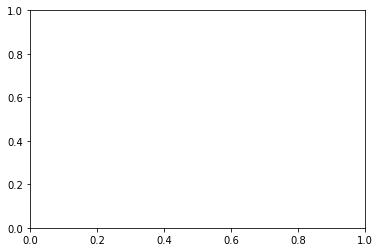

In [113]:
import matplotlib.pyplot as plot

plot.plot(list(Counter(user_topic_scores.argmax(axis=1)).values()),density=1, bins=20) 

In [67]:
col_names = []
for line in open(os.path.join('../data/raw/coat/user_item_features', 'item_features_map.txt'), 'r'):
    col_names.append(line.strip())


In [68]:
col_names

['gender:men',
 'gender:women',
 'jackettype:bomber',
 'jackettype:cropped',
 'jackettype:field',
 'jackettype:fleece',
 'jackettype:insulated',
 'jackettype:motorcycle',
 'jackettype:other',
 'jackettype:packable',
 'jackettype:parkas',
 'jackettype:pea',
 'jackettype:rain',
 'jackettype:shells',
 'jackettype:track',
 'jackettype:trench',
 'jackettype:vests',
 'jackettype:waterproof',
 'color:beige',
 'color:black',
 'color:blue',
 'color:brown',
 'color:gray',
 'color:green',
 'color:multi',
 'color:navy',
 'color:olive',
 'color:other',
 'color:pink',
 'color:purple',
 'color:red',
 'onfrontpage:yes',
 'onfrontpage:no']

In [69]:
item_feats = np.loadtxt(os.path.join('../data/raw/coat/user_item_features', 'item_features.ascii'))

In [82]:
np.where(item_feats.T == 1)

(array([ 0,  0,  0, ..., 32, 32, 32]),
 array([  0,   1,   2, ..., 297, 298, 299]))

In [41]:
y_pred_mf = history_mf.model.predict(X_test)

In [51]:
y_pred_mf.max()

5.536191

In [94]:
history_mf.model.get_weights()

[array([[-0.19978216, -0.1537097 , -0.19424263, ...,  0.17286858,
         -0.25711918,  0.10904978],
        [-0.05090541, -0.03899537, -0.09592912, ...,  0.08447007,
         -0.07513382,  0.14959675],
        [-0.10448894, -0.13059027, -0.10833335, ...,  0.16680837,
          0.04283736,  0.06519396],
        ...,
        [-0.09738317, -0.08344048, -0.16746895, ...,  0.11266895,
          0.16250823,  0.14642015],
        [-0.10171963, -0.07801136, -0.12614352, ...,  0.10504811,
         -0.04448077,  0.14472958],
        [-0.07229791, -0.1351395 , -0.12186116, ...,  0.09137271,
          0.07827122,  0.1677315 ]], dtype=float32),
 array([[-0.3667073 , -0.37699977, -0.31040722, ...,  0.14624433,
         -0.10071659,  0.45431462],
        [-0.15642197, -0.3445183 , -0.35588202, ...,  0.42915514,
         -0.18906666,  0.09793819],
        [-0.33941808, -0.34788367, -0.2758867 , ...,  0.2938753 ,
          0.02278627,  0.420508  ],
        ...,
        [-0.22543044, -0.38158324, -0.2